# Pré-Processamento dos Dados
## Imports

In [1]:
import numpy as np
import pandas as pd
import time
import scipy.sparse as sps
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from IPython.core.display import HTML

# Carregando os dados

In [44]:
df_train = pd.read_csv('./data/train.csv', encoding='utf8')
df_test  = pd.read_csv('./data/test.csv' , encoding='utf8')

In [3]:
exibir_dataframe = lambda dataframe: display(HTML(dataframe.head(5).to_html()))
exibir_dataframe(df_train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Identificando colunas

In [5]:
numeric_columns     = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt',      \
                       'YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',   \
                       '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',    \
                       'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces',   \
                       'GarageYrBlt','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',\
                       '3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

categorical_columns = ['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',    \
                       'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',    \
                       'RoofStyle','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond',    \
                       'Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2', \
                       'Heating','HeatingQC','CentralAir','Electrical','KitchenQual', 'Functional',     \
                       'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive',\
                       'PoolQC','Fence','MiscFeature','SaleType','SaleCondition']

exibir_dataframe(df_train[categorical_columns])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


# Preenchendo dados faltantes com a mediana

In [6]:
for column in numeric_columns:
    serie_all_data = pd.concat([df_train[column],df_test[column]])
    df_test[column].fillna(value=serie_all_data.median(), inplace=True)
    df_train[column].fillna(value=serie_all_data.median(), inplace=True)
    print("Dados faltantes de coluna "+ column +" preenchidos com "+str(serie_all_data.median()))

Dados faltantes de coluna MSSubClass preenchidos com 50.0
Dados faltantes de coluna LotFrontage preenchidos com 68.0
Dados faltantes de coluna LotArea preenchidos com 9453.0
Dados faltantes de coluna OverallQual preenchidos com 6.0
Dados faltantes de coluna OverallCond preenchidos com 5.0
Dados faltantes de coluna YearBuilt preenchidos com 1973.0
Dados faltantes de coluna YearRemodAdd preenchidos com 1993.0
Dados faltantes de coluna MasVnrArea preenchidos com 0.0
Dados faltantes de coluna BsmtFinSF1 preenchidos com 368.5
Dados faltantes de coluna BsmtFinSF2 preenchidos com 0.0
Dados faltantes de coluna BsmtUnfSF preenchidos com 467.0
Dados faltantes de coluna TotalBsmtSF preenchidos com 989.5
Dados faltantes de coluna 1stFlrSF preenchidos com 1082.0
Dados faltantes de coluna 2ndFlrSF preenchidos com 0.0
Dados faltantes de coluna LowQualFinSF preenchidos com 0.0
Dados faltantes de coluna GrLivArea preenchidos com 1444.0
Dados faltantes de coluna BsmtFullBath preenchidos com 0.0
Dados fa

# Criando listas para armazenar resultado do pré-processamento

In [7]:
matrizes_train_resultado = []
matrizes_test_resultado = []

# Processamento de colunas categóricas

In [8]:
def dropcols_coo(M, idx_to_drop):
    # Apaga coluna idx_to_drop em matriz esparsa M
    idx_to_drop = np.unique(idx_to_drop)
    C = M.tocoo()
    M = None
    keep = ~np.in1d(C.col, idx_to_drop)
    C.data, C.row, C.col = C.data[keep], C.row[keep], C.col[keep]
    C.col -= idx_to_drop.searchsorted(C.col)    
    C._shape = (C.shape[0], C.shape[1] - len(idx_to_drop))
    return C.tocsr()

num_linhas_treino = df_train.shape[0]
 
def hotEncodar(column, apagar_coluna_antiga = True):
    
    df_all_data = pd.DataFrame()
    df_all_data[column] = pd.concat([df_train[column],df_test [column]],copy=False)    
    df_all_data[column] = df_all_data[column].astype(str, copy = False)
    
     # fit labels
    label_enc = preprocessing.LabelEncoder() 
    label_enc.fit(df_all_data[column])
    
    # transform labels
    column_label_encoded = label_enc.transform(df_all_data[column]).reshape(-1,1) 
    df_all_data = None
        
    # fit e transform usando OneHotEncoder
    one_hot_enc = OneHotEncoder(sparse=True)
    column_transformed = one_hot_enc.fit_transform(column_label_encoded)
    
    # particionando resultado
    train_column_transformed = column_transformed[:num_linhas_treino]
    test_column_transformed  = column_transformed[num_linhas_treino:]
    column_transformed = None
    
    # removendo coluna linearmente dependente do resultado
    indice_ultima_coluna = train_column_transformed.shape[1]-1
    train_column_transformed = dropcols_coo(train_column_transformed, indice_ultima_coluna) 
    indice_ultima_coluna = test_column_transformed.shape[1]-1
    test_column_transformed = dropcols_coo(test_column_transformed, indice_ultima_coluna)
    
    # apagando colunas antigas
    df_train.drop(columns=[column], inplace=True)
    df_test.drop(columns=[column], inplace=True)
    
    # Salvando matrizes de resultado
    matrizes_train_resultado.append(train_column_transformed)
    matrizes_test_resultado.append(test_column_transformed)
    
    print('Coluna '+column+' transformada em '+str(one_hot_enc.n_values_[0] -1) +' colunas linearmente independentes')
    
for column in categorical_columns:
    hotEncodar(column)

# Limpando memória
train_column_transformed = None
test_column_transformed  = None

Coluna MSZoning transformada em 5 colunas linearmente independentes
Coluna Street transformada em 1 colunas linearmente independentes
Coluna Alley transformada em 2 colunas linearmente independentes
Coluna LotShape transformada em 3 colunas linearmente independentes
Coluna LandContour transformada em 3 colunas linearmente independentes
Coluna Utilities transformada em 2 colunas linearmente independentes
Coluna LotConfig transformada em 4 colunas linearmente independentes
Coluna LandSlope transformada em 2 colunas linearmente independentes
Coluna Neighborhood transformada em 24 colunas linearmente independentes
Coluna Condition1 transformada em 8 colunas linearmente independentes
Coluna Condition2 transformada em 7 colunas linearmente independentes
Coluna BldgType transformada em 4 colunas linearmente independentes
Coluna HouseStyle transformada em 7 colunas linearmente independentes
Coluna RoofStyle transformada em 5 colunas linearmente independentes
Coluna Exterior1st transformada em 

# Normalização dos dados

In [9]:

df_all_data = pd.concat([df_train[numeric_columns],df_test[numeric_columns]],copy=False)

# Escalando colunas numéricas 
scaler = MinMaxScaler(copy=False)
scaler.fit(df_all_data[numeric_columns])
train_matriz_scaled = scaler.transform(df_train[numeric_columns])
test_matriz_scaled  = scaler.transform(df_test[numeric_columns])
    
# Salvando matrizes de resultado
matrizes_train_resultado.append(train_matriz_scaled)
matrizes_test_resultado.append(test_matriz_scaled)

# Concatenando Matrizes esparsas para o resultado

In [10]:
# Matrizes esparsas
matriz_train = sps.hstack(matrizes_train_resultado).tocsr()
matriz_test  = sps.hstack(matrizes_test_resultado).tocsr()

print("Dimensões da matriz de treino: "+str(matriz_train.shape[0])+"x"+str(matriz_train.shape[1]))
print("Dimensões da matriz de teste: "+str(matriz_test.shape[0])+"x"+str(matriz_test.shape[1]))

Dimensões da matriz de treino: 1460x261
Dimensões da matriz de teste: 1459x261


# Regressão

In [31]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

vetor_train_target = df_train['SalePrice']

## Configuração da validação cruzada (k-Fold)

In [16]:
#np.random.seed(0) - random_state

# A validação cruzada é feita através de análise de partições pequenas
# e mutuamente exclusivas dos datasets originais

# Quantidade de divisões a serem usadas pelo k-fold
n_splits = 50

# Regressor Linear

Tempo de processamento do regressor linear: 19.89s


RMSE MEAN:  0.1812
RMSE STD:   0.1009 




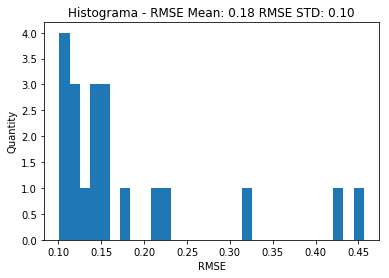

In [33]:
from sklearn.linear_model import LinearRegression

start = time.time()

rmse_list =[]
X = matriz_train
y = np.log(vetor_train_target)

kf = KFold(n_splits=n_splits);

# Validação cruzada    
for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
        
    # Criando Regressor Linear
    regr = LinearRegression(n_jobs = -1)
    
    # Treino
    regr.fit(X_train, y_train) 
    
    # Predição     
    y_pred = regr.predict(X_test)
    
    #Root mean squared error
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)));

end = time.time()

print('Tempo de processamento do regressor linear: '+str("%.2f" % (end - start))+'s\n\n')
print("RMSE MEAN: ","%.4f" % np.mean(rmse_list))
print("RMSE STD:  ","%.4f" % np.std(rmse_list), '\n\n')

plt.title(u"Histograma - RMSE Mean: " + str("%.2f" % np.mean(rmse_list))+ " RMSE STD: " + str("%.2f" % np.std(rmse_list)))
plt.ylabel("Quantity")
plt.xlabel("RMSE")

plt.hist(rmse_list,bins = 30)
plt.show()

# Regressor Ridge

Tempo de processamento do regressor Ridge: 5.22s


RMSE MEAN:  0.1384
RMSE STD:   0.0346 




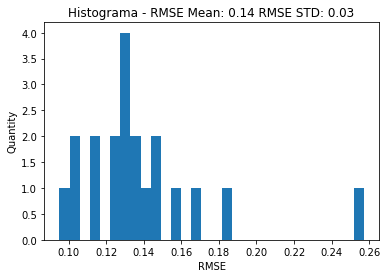

In [38]:
from sklearn.linear_model import Ridge

start = time.time()

rmse_list =[]
X = matriz_train
y = np.log(vetor_train_target)

kf = KFold(n_splits=n_splits);

# Validação cruzada    
for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
        
    # Criando Regressor Ridge
    # Este alpha foi escolhido variando seu valor, até obter o melhor RMSE
    regr = Ridge(alpha = 3.0, fit_intercept=True)
    
    # Treino
    regr.fit(X_train, y_train) 
    
    # Predição     
    y_pred = regr.predict(X_test)
    
    #Root mean squared error
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)));

end = time.time()

print('Tempo de processamento do regressor Ridge: '+str("%.2f" % (end - start))+'s\n\n')
print("RMSE MEAN: ","%.4f" % np.mean(rmse_list))
print("RMSE STD:  ","%.4f" % np.std(rmse_list), '\n\n')

plt.title(u"Histograma - RMSE Mean: " + str("%.2f" % np.mean(rmse_list))+ " RMSE STD: " + str("%.2f" % np.std(rmse_list)))
plt.ylabel("Quantity")
plt.xlabel("RMSE")

plt.hist(rmse_list,bins = 30)
plt.show()

# SVM Regressor

Tempo de processamento do SVM regressor: 151.98s


RMSE MEAN:  0.1398
RMSE STD:   0.0505 




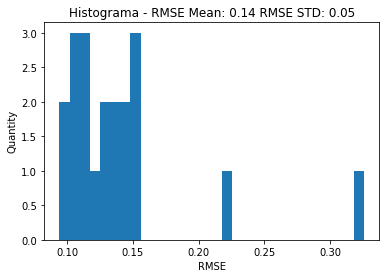

In [39]:
from sklearn.svm import SVR

start = time.time()

rmse_list =[]
X = matriz_train
y = np.log(vetor_train_target)

kf = KFold(n_splits=n_splits);

# Validação cruzada    
for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
        
    # Criando SVM Regressor
    regr = SVR('linear')
    
    # Treino
    regr.fit(X_train, y_train) 
    
    # Predição     
    y_pred = regr.predict(X_test)
    
    #Root mean squared error
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)));

end = time.time()

print('Tempo de processamento do regressor SVM: '+str("%.2f" % (end - start))+'s\n\n')
print("RMSE MEAN: ","%.4f" % np.mean(rmse_list))
print("RMSE STD:  ","%.4f" % np.std(rmse_list), '\n\n')

plt.title(u"Histograma - RMSE Mean: " + str("%.2f" % np.mean(rmse_list))+ " RMSE STD: " + str("%.2f" % np.std(rmse_list)))
plt.ylabel("Quantity")
plt.xlabel("RMSE")

plt.hist(rmse_list,bins = 30)
plt.show()

# Regressor KNN

Tempo de processamento do regressor KNN: 142.25s


RMSE MEAN:  0.2102
RMSE STD:   0.0281 




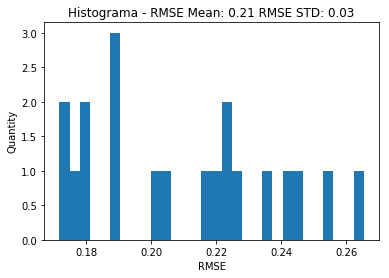

In [41]:
from sklearn.neighbors import KNeighborsRegressor

start = time.time()

rmse_list =[]
X = matriz_train
y = np.log(vetor_train_target)

kf = KFold(n_splits=n_splits);

# Validação cruzada    
for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
        
    # Criando Regressor KNN
    regr =  KNeighborsRegressor(n_jobs=-1, n_neighbors=30)
    
    # Treino
    regr.fit(X_train, y_train) 
    
    # Predição     
    y_pred = regr.predict(X_test)
    
    #Root mean squared error
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)));

end = time.time()

print('Tempo de processamento do regressor KNN: '+str("%.2f" % (end - start))+'s\n\n')
print("RMSE MEAN: ","%.4f" % np.mean(rmse_list))
print("RMSE STD:  ","%.4f" % np.std(rmse_list), '\n\n')

plt.title(u"Histograma - RMSE Mean: " + str("%.2f" % np.mean(rmse_list))+ " RMSE STD: " + str("%.2f" % np.std(rmse_list)))
plt.ylabel("Quantity")
plt.xlabel("RMSE")

plt.hist(rmse_list,bins = 30)
plt.show()

# Regressor XGBoost

In [42]:
from xgboost import XGBRegressor

start = time.time()

rmse_list =[]
X = matriz_train
y = np.log(vetor_train_target)

kf = KFold(n_splits=n_splits);

# Validação cruzada    
for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
        
    # Criando Regressor XGB
    regr =  XGBRegressor(n_estimators=30)
    
    # Treino
    regr.fit(X_train, y_train) 
    
    # Predição     
    y_pred = regr.predict(X_test)
    
    #Root mean squared error
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)));

end = time.time()

print('Tempo de processamento do regressor XGB: '+str("%.2f" % (end - start))+'s\n\n')
print("RMSE MEAN: ","%.4f" % np.mean(rmse_list))
print("RMSE STD:  ","%.4f" % np.std(rmse_list), '\n\n')

plt.title(u"Histograma - RMSE Mean: " + str("%.2f" % np.mean(rmse_list))+ " RMSE STD: " + str("%.2f" % np.std(rmse_list)))
plt.ylabel("Quantity")
plt.xlabel("RMSE")

plt.hist(rmse_list,bins = 30)
plt.show()

ModuleNotFoundError: No module named 'xgboost'

# Utilizando regressor em dados de teste

In [43]:
X_train = matriz_train
y_train = vetor_train_target
X_test  = matriz_test

# Criando Regressor Ridge
regr = Ridge(alpha = 3.0, fit_intercept=True)

# Treino
regr.fit(X_train, y_train) 

# Predição      
y_pred = regr.predict(X_test)

# Salvando o resultado

In [45]:
df_y_pred = pd.DataFrame(y_pred, columns = ['SalePrice'])
df_resultado = pd.concat([df_test["Id"],df_y_pred],axis =1)
df_resultado.to_csv('submission.csv', encoding='utf-8', index=False)